### <u> Machine Learning</u>


Let's start with imports and reading the CSV file:

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix 
import numpy as np

In [2]:
df = pd.read_csv('combined_finished_df.csv')

------------
Declaring variables to use with train_test method

In [3]:
y = df['Rating']
text = df['Description']
X = df.drop(columns = ['Rating'])

Let's divide the data to 2 different sections, Categorical ones and Numericals:

In [4]:
# Extracting only the categoricals features 
categoricals = list(X.select_dtypes('object').columns)
categoricals.remove('Description')

# Defining a list containing numerical columns only
numericals = list(X.select_dtypes(exclude=['object']).columns)
if 'Unnamed: 0' in numericals: # Using Pandas always adds a redundant column, so it should be removed.
    numericals.remove('Unnamed: 0')

---------

After some research on the internet, I came across a more suitable tool other than CountVectorizer.

(Sources: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

"The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents."

Processing the description feature into a numerical representation using TfidVectorizer to learn an embedding for our words space.

In [5]:
# limiting the process to recognize only words that are shown more than 50 times
# max_features parameter meaning is limiting the vocabulary to an upper bound of the specified number
tfidf = TfidfVectorizer(min_df=50, max_features=80000)

# Creating a DataFrame containing the embedding: vector representation of text features.
v = tfidf.fit_transform(text)
embedding = pd.DataFrame(v.toarray().astype(np.uint8), columns = tfidf.get_feature_names())

-----------
Sources:
https://www.mygreatlearning.com/blog/label-encoding-in-python/

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In the following block of code, I'll use LabelEncoder, which helps encoding the features into numbers.

In [6]:
# Initializing LabelEncoder, training the features and adding it to a list

features = []
for feature in categoricals:
    # Encoding each categorical feature. The reason to do this iterativly
    # and not for all the categoricals features once is because accessing it non-iterativly
    # way messes up the labels
    encoder = LabelEncoder()
    encoder = encoder.fit(X[feature])
    encoded = encoder.transform(X[feature])
    encoded = np.array(encoded)
    features.append(encoded)

# Features holds the encoded categorical variables
features = np.array(features)
features = np.transpose(features) # Had a problem here with array dimensions, that was the solution.

features = pd.DataFrame(features,columns=categoricals)

# num_features holds all numerical features for scaling
num_features = pd.concat([X[numericals], features], axis=1)

# Initializing
scaler = StandardScaler()
scaler = scaler.fit(num_features)

features = scaler.transform(num_features)
features = pd.DataFrame(features,columns=numericals+categoricals)

In [7]:
# Combining the encoded dataframe (which holds both the numerical
# and categorical features) with the embedding of the description feature.
final_df = pd.concat([features, embedding], axis=1)

In [8]:
# There was a problem with max_iter parameter, link to solution from StackOverflow:
# https://stackoverflow.com/a/62659927/15633316
# parameter explanation: Maximum number of iterations taken for the solvers to converge.
pipeline = Pipeline(steps=[('model', LogisticRegression(random_state=42, max_iter=500))])

In [9]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid = {'model__C': [0.5,1,50]}
grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = grid,
                           cv = 5,
                           return_train_score=True)
grid_search.fit(final_df, y)

E:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
E:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             param_grid={'model__C': [0.5, 1, 50]}, return_train_score=True)

In [10]:
print(f"Average train score: {grid_search.cv_results_['mean_train_score'].mean()}")
print(f"Average Test score: {grid_search.cv_results_['mean_test_score'].mean()}")

Average train score: 0.8540859172791366
Average Test score: 0.8540262329147102


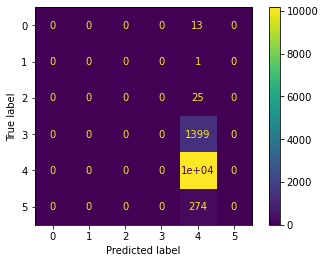

In [11]:
estimator = grid_search.best_estimator_['model']
# NOTE: For GridSearch we didn't need to split the dataset because 
# it does cross-validation for us, hence for gathering more information
# from confusion matrix we sample a test data for visualization purpose.
X_train, X_test, y_train, y_test = train_test_split(final_df,y)

plot_confusion_matrix(estimator, X_test, y_test)

In [12]:
pipeline1= Pipeline(steps=[('model',DecisionTreeClassifier(random_state=42))])
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

grid = {'model__max_depth': [10,50,100,None]}
grid_search = GridSearchCV(estimator = pipeline1,
                           param_grid = grid,
                           cv = 5,
                           return_train_score=True)
grid_search.fit(final_df, y)

E:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__max_depth': [10, 50, 100, None]},
             return_train_score=True)

In [13]:
print(f"Average train score: {grid_search.cv_results_['mean_train_score'].mean()}")
print(f"Average Test score: {grid_search.cv_results_['mean_test_score'].mean()}")

Average train score: 0.9655902427815052
Average Test score: 0.7754992166555569


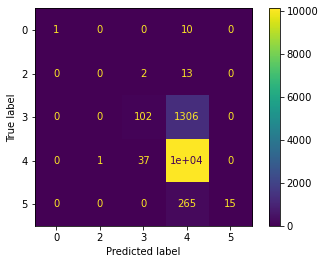

In [14]:
estimator = grid_search.best_estimator_['model']
X_train, X_test, y_train, y_test = train_test_split(final_df,y)

plot_confusion_matrix(estimator, X_test, y_test)